# Extract annotation information from TCDB

Note: Requires internet connection to download information from [Transport Classification Database (TCDB)](https://www.tcdb.org/).

## Setup
### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    ROOT_PATH,
    DATABASE_PATH,
    ANNOTATION_PATH,
    INTERIM_PATH,
    GEM_NAME,
    read_rbc_model,
    get_annotation_df,
    compare_tables,
    visualize_comparison,
    show_versions,
    split_string,
    build_string,
)

from rbc_gem_utils.database.tcdb import (
    download_database_TCDB,
    TCDB_PATH,
    TCDB_DB_TAG,
)

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

In [2]:
model = read_rbc_model(filetype="xml")
model

Name,RBC_GEM
Memory address,1472450d0
Number of metabolites,1967
Number of reactions,2788
Number of genes,653
Number of groups,74
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Check TCDB version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 

### Last update: Feb 6th, 2024
* According to the [TCDB FAQ](https://www.tcdb.org/faq.php), updates are usually every week, but it mainly depends on the availability of new data.

In [3]:
database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
overwrite = True
display_nunique = True
compare = True
download = True

#### Download new files and update database

In [4]:
if download:
    download_database_TCDB(database_dirpath=f"{database_dirpath}{TCDB_PATH}")

## Load RBC-GEM model

In [5]:
model = read_rbc_model(filetype="xml")
model

Name,RBC_GEM
Memory address,148a1dd90
Number of metabolites,1967
Number of reactions,2788
Number of genes,653
Number of groups,74
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [6]:
annotation_type = "genes"
# TCDB is best if all mappings are up to date, UniProt may not work if TCDB maps to a secondary accession
mapping_key = "tcdb"

df_model_mappings = (
    get_annotation_df(model.genes, ["tcdb", "uniprot"])
    .rename({"id": annotation_type}, axis=1)
    .dropna(subset=[mapping_key])
)
for col in df_model_mappings.columns:
    df_model_mappings[col] = df_model_mappings[col].apply(lambda x: split_string(x))
    df_model_mappings = df_model_mappings.explode(col).drop_duplicates()
df_model_mappings

,genes,tcdb,uniprot
20,SLC14A1,1.A.28.1.5,Q13336
26,SLC2A3,2.A.1.1.91,P11169
27,SLC2A4,2.A.1.1.80,P14672
35,SLC6A9,2.A.22.2.12,P48067
49,SLC4A1,2.A.31.1.1,P02730
...,...,...,...
643,SLC12A4,2.A.30.1.17,Q9UP95
645,FXN,9.B.21.1.1,Q16595
646,SCN9A,1.A.1.10.5,Q15858
647,SCN4A,1.A.1.10.4,P35499


### Load identifier tables

In [7]:
df_accessions = pd.read_csv(
    f"{database_dirpath}{TCDB_PATH}/tcdb_acc2tcid.tsv",
    sep="\t",
    header=None,
    names=["uniprot", "tcdb"],
    on_bad_lines="error",
    dtype=str,
)
df_families = pd.read_csv(
    f"{database_dirpath}{TCDB_PATH}/tcdb_families.tsv",
    sep="\t",
    header=None,
    names=["Family", "Name"],
    on_bad_lines="error",
    dtype=str,
)
df_superfamilies = pd.read_csv(
    f"{database_dirpath}{TCDB_PATH}/tcdb_listSuperfamilies.tsv",
    sep="\t",
    on_bad_lines="warn",  # Known issue line:7700, field is duplicated so its okay to skip.
    dtype=str,
)

df_families = df_families.merge(
    df_superfamilies,
    left_on="Family",
    right_on="Family",
    how="left",
).drop_duplicates()
df_families

/var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/ipykernel_12860/408952954.py:17: ParserWarning: Skipping line 7700: expected 5 fields, saw 6

  df_superfamilies = pd.read_csv(


,Family,Name,#TCID,Subfamily,Fam_abbreviation,Superfamily
0,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.1.1,1.A.1.1,VIC,VIC Superfamily
1,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.10.1,1.A.1.10,VIC,VIC Superfamily
2,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.10.10,1.A.1.10,VIC,VIC Superfamily
3,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.10.11,1.A.1.10,VIC,VIC Superfamily
4,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.10.12,1.A.1.10,VIC,VIC Superfamily
...,...,...,...,...,...,...
12217,9.C.5,The Endoplasmic Reticulum/Golgi ATP/ADP or AMP...,NaN,NaN,NaN,NaN
12218,9.C.6,The Mitochondrial Organic Anion Channel (MOAC)...,NaN,NaN,NaN,NaN
12219,9.C.7,"The Low-affinity, Calcium-blocked, Nonspecific...",NaN,NaN,NaN,NaN
12220,9.C.8,The ABC Lignin Precursor Transporters (ALPT) F...,NaN,NaN,NaN,NaN


### Create data table

In [8]:
df_model_tcdb = df_model_mappings.merge(
    df_accessions,
    left_on=mapping_key,
    right_on=mapping_key,
    how="left",
    suffixes=("_MODEL", ""),
)
df_model_tcdb = df_model_tcdb.drop(
    labels=[x for x in df_model_tcdb.columns if x.endswith("_MODEL")], axis=1
)
df_model_tcdb = df_model_tcdb.dropna().drop_duplicates().reset_index(drop=True)

df_model_tcdb = (
    df_model_tcdb.merge(
        df_families,
        left_on="tcdb",
        right_on="#TCID",
        how="left",
    )
    .rename({c: c.lower() for c in df_families.columns}, axis=1)
    .drop("#tcid", axis=1)
)

for filename in ["pfam", "refseq", "pdb", "go", "getSubstrates"]:
    if filename == "getSubstrates":
        df = pd.read_csv(
            f"{database_dirpath}{TCDB_PATH}/tcdb_getSubstrates.tsv",
            sep="\t",
            header=None,
            names=["tcdb", "chebi"],
        )
        df["chebi"] = df["chebi"].str.split("|")
        df["substrate"] = df["chebi"].apply(
            lambda x: build_string([s.split(";")[-1] for s in x])
        )
        df["chebi"] = df["chebi"].apply(
            lambda x: build_string([s.split(";")[0] for s in x])
        )

    else:
        df = pd.read_csv(
            f"{database_dirpath}{TCDB_PATH}/tcdb_{filename}.tsv",
            sep="\t",
            header=None,
            names=[filename, "tcdb", "family"],
        ).drop("family", axis=1)

    df_model_tcdb = df_model_tcdb.merge(
        df.set_index("tcdb"),
        left_on="tcdb",
        right_on="tcdb",
        how="left",
    ).reset_index(drop=True)

df_model_tcdb = (
    df_model_tcdb.groupby(["genes", "tcdb", "uniprot"], as_index=False)
    .agg(lambda x: build_string(list(x.dropna().unique())))
    .drop_duplicates()
)
df_model_tcdb["subfamily"] = (
    df_model_tcdb["tcdb"].str.findall(r"^\w+\W\w+\W\w+\W\w+").explode()
)
df_model_tcdb["family"] = df_model_tcdb["tcdb"].str.findall(r"^\w+\W\w+\W\w+").explode()
df_model_tcdb["subclass"] = df_model_tcdb["tcdb"].str.findall(r"^\w+\W\w+").explode()
df_model_tcdb["class"] = df_model_tcdb["tcdb"].str.findall(r"^\w+").explode()
df_model_tcdb = df_model_tcdb.loc[
    :,
    [
        "genes",
        "uniprot",
        "tcdb",
        "subfamily",
        "family",
        "subclass",
        "class",
        "fam_abbreviation",
        "superfamily",
        "name",
        "pfam",
        "refseq",
        "pdb",
        "go",
        "chebi",
        "substrate",
    ],
]
# df_model_tcdb = df_model_tcdb.rename({"go": "GO"}, axis=1)
df_model_tcdb_final = df_model_tcdb.groupby(["genes", "tcdb"], as_index=False).agg(
    lambda x: build_string(x.unique())
)
df_model_tcdb_final = df_model_tcdb_final.replace("", float("nan"))

if display_nunique:
    for col in df_model_tcdb_final.columns:
        df = (
            df_model_tcdb_final[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")


if overwrite:
    df_model_tcdb_final.to_csv(
        f"{database_dirpath}/{TCDB_DB_TAG}_{GEM_NAME}.tsv", sep="\t"
    )
else:
    df_model_tcdb_final.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{TCDB_DB_TAG}_{GEM_NAME}.tsv", sep="\t"
    )
df_model_tcdb_final

genes: 129
tcdb: 129
uniprot: 165
subfamily: 86
family: 63
subclass: 12
class: 7
fam_abbreviation: 34
superfamily: 19
name: 34
pfam: 80
refseq: 122
pdb: 803
go: 630
chebi: 185
substrate: 180


,genes,tcdb,uniprot,subfamily,family,subclass,class,fam_abbreviation,superfamily,name,pfam,refseq,pdb,go,chebi,substrate
0,ABCA1,3.A.1.211.14,O95477,3.A.1.211,3.A.1,3.A,3,ABC,ArsA ATPase (ArsA) Superfamily,The ATP-binding Cassette (ABC) Superfamily,NaN,NaN,5XJY,NaN,CHEBI:22563;CHEBI:53002;CHEBI:16247;CHEBI:3659,anion;amyloid-beta;phospholipid;cholesterol
1,ABCA7,3.A.1.211.10,Q8IZY2,3.A.1.211,3.A.1,3.A,3,ABC,ArsA ATPase (ArsA) Superfamily,The ATP-binding Cassette (ABC) Superfamily,PF00005,NaN,NaN,GO:0016324;GO:0043190;GO:0010008;GO:0000139;GO...,CHEBI:8150;CHEBI:7242,phospholipid;ceramide
2,ABCB1,3.A.1.201.1,P08183,3.A.1.201,3.A.1,3.A,3,ABC,ArsA ATPase (ArsA) Superfamily,The ATP-binding Cassette (ABC) Superfamily,PF00664;PF00005,NP_000918.2,6C0V;6FN1;6FN4;6QEX,GO:0009986;GO:0016021;GO:0005624;GO:0005524;GO...,CHEBI:23888,drug
3,ABCB4,3.A.1.201.3,P21439,3.A.1.201,3.A.1,3.A,3,ABC,ArsA ATPase (ArsA) Superfamily,The ATP-binding Cassette (ABC) Superfamily,PF00664;PF00005,NP_000434.1;NP_061337.1,6S7P,GO:0005887;GO:0005624;GO:0005524;GO:0008559;GO...,CHEBI:22868;CHEBI:8128;CHEBI:27375;CHEBI:7887;...,"bile salt;1,2-diacyl-sn-glycero-3-phosphocholi..."
4,ABCB6,3.A.1.210.6,Q9NP58,3.A.1.210,3.A.1,3.A,3,ABC,ArsA ATPase (ArsA) Superfamily,The ATP-binding Cassette (ABC) Superfamily,PF00664;PF00005,NP_005680.1,3NH6;3NH9;3NHA;3NHB,GO:0043190;GO:0016021;GO:0005741;GO:0005524;GO...,CHEBI:8337,porphyrin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,TRPV2,1.A.4.2.8,Q9Y5S1,1.A.4.2,1.A.4,1.A,1,TRP-CC,VIC Superfamily,The Transient Receptor Potential Ca2+/Cation C...,PF00023,NP_057197.2,2F37,GO:0005887;GO:0042470;GO:0005262;GO:0006816;GO...,CHEBI:3308;CHEBI:36915,calcium(2+);inorganic cation
130,TSPO2,9.A.24.1.17,Q5TGU0,9.A.24.1,9.A.24,9.A,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEBI:17549,5-aminolevulinic acid
131,VCP,3.A.16.1.1,P55072;Q541A5;Q6GYA4;Q8TAT6;Q8UZK5;Q9BUN8,3.A.16.1,3.A.16,3.A,3,ER-RT,AAA-ATPase Superfamily,The Endoplasmic Reticular Retrotranslocon (ER-...,PF00004;PF02933;PF02359;PF09336;PF04511;PF0693...,NP_009057.1;NP_001128143.1;NP_077271.1;NP_0056...,3EBB;3HU1;3HU2;3HU3;3QC8;3QQ7;3QQ8;3QWZ;3TIW;4...,GO:0005829;GO:0005783;GO:0005792;GO:0005634;GO...,CHEBI:36080,protein
132,VDAC2,1.B.8.1.12,P45880,1.B.8.1,1.B.8,1.B,1,MPP,Outer Membrane Pore-forming Protein I (OMPP-I)...,The Mitochondrial and Plastid Porin (MPP) Family,NaN,NaN,NaN,NaN,CHEBI:22563,anion


genes: 129
tcdb: 129
uniprot: 165
pfam: 81
refseq: 123
pdb: 803
go: 631


,genes,tcdb,uniprot,pfam,refseq,pdb,go
0,ABCA1,3.A.1.211.14,O95477,NaN,NaN,5XJY,NaN
1,ABCA7,3.A.1.211.10,Q8IZY2,PF00005,NaN,NaN,GO:0000139;GO:0005215;GO:0005524;GO:0005548;GO...
2,ABCB1,3.A.1.201.1,P08183,PF00005;PF00664,NP_000918.2,6C0V;6FN1;6FN4;6QEX,GO:0005515;GO:0005524;GO:0005624;GO:0008559;GO...
3,ABCB4,3.A.1.201.3,P21439,PF00005;PF00664,NP_000434.1;NP_061337.1,6S7P,GO:0005524;GO:0005624;GO:0005887;GO:0006629;GO...
4,ABCB6,3.A.1.210.6,Q9NP58,PF00005;PF00664,NP_005680.1,3NH6;3NH9;3NHA;3NHB,GO:0005524;GO:0005741;GO:0006879;GO:0016021;GO...
...,...,...,...,...,...,...,...
124,TRPV2,1.A.4.2.8,Q9Y5S1,PF00023,NP_057197.2,2F37,GO:0005262;GO:0005887;GO:0006816;GO:0007600;GO...
125,TSPO2,9.A.24.1.17,Q5TGU0,NaN,NaN,NaN,NaN
126,VCP,3.A.16.1.1,P55072;Q541A5;Q6GYA4;Q8TAT6;Q8UZK5;Q9BUN8,PF00004;PF02359;PF02933;PF03152;PF04511;PF0502...,NP_001128143.1;NP_005650.2;NP_009057.1;NP_0603...,3EBB;3HU1;3HU2;3HU3;3QC8;3QQ7;3QQ8;3QWZ;3TIW;4...,GO:0000502;GO:0004872;GO:0005515;GO:0005524;GO...
127,VDAC2,1.B.8.1.12,P45880,NaN,NaN,NaN,NaN


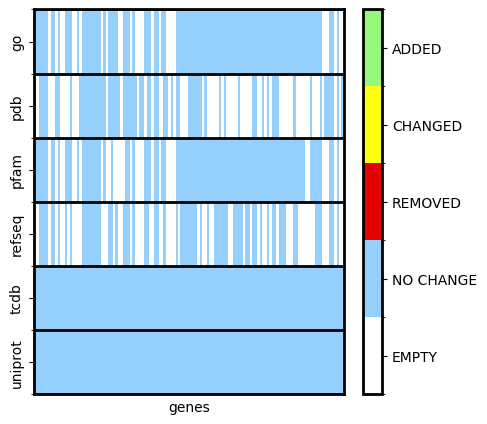

In [9]:
df_annotations = df_model_tcdb.loc[
    :, [annotation_type] + ["tcdb", "uniprot", "pfam", "refseq", "pdb", "go"]
]
# Explode and regroup to reduce duplicate mappings to genes
for col in df_annotations.columns:
    df_annotations[col] = df_annotations[col].apply(lambda x: split_string(x))
    df_annotations = df_annotations.explode(col).drop_duplicates()
df_annotations = df_annotations.groupby(["genes"], as_index=False).agg(
    lambda x: build_string(sorted(x.unique()))
)
df_annotations = df_annotations.replace("", float("nan"))
if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{TCDB_DB_TAG}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")


if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{TCDB_DB_TAG}.tsv", sep="\t"
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{TCDB_DB_TAG}.tsv", sep="\t"
    )
df_annotations